<a href="https://colab.research.google.com/github/Hedrios/Pipeline_de_dados_do_Telegram/blob/main/Pipeline_de_dados_do_Telegram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pipeline de dados do Telegram**

---

# **1. Contexto**

Com o aumento do uso de chatbots em plataformas de mensagens como o Telegram, as empresas encontram novas oportunidades para melhorar o atendimento ao cliente e automatizar interações repetitivas. Em especial, o Telegram é amplamente adotado por sua facilidade de integração com bots, permitindo a captura de dados de conversas para análise. No entanto, para extrair valor dessas interações, é necessário organizar os dados de maneira eficiente, desde sua ingestão até a análise final, de modo que insights possam ser extraídos de forma rápida e escalável.

Neste cenário, um pipeline de dados robusto é essencial. Este pipeline captura mensagens enviadas ao bot do Telegram, processa essas informações e as armazena de forma organizada para análise. Com a infraestrutura fornecida pela AWS, o pipeline permite que as mensagens sejam coletadas, transformadas e armazenadas de maneira a suportar uma ampla gama de análises. Este pipeline de dados oferece, assim, uma visão clara e organizada sobre o comportamento dos usuários e a eficiência do chatbot, possibilitando aprimoramentos no atendimento e na interação com os clientes.

### **1.1. Chatbot**

Um **chatbot** é um tipo de software que interage com usuários através de conversas automatizadas em plataformas de mensagens. Uma aplicação comum de **chatbots** é o seu uso no atendimento ao cliente, onde, de maneira geral, ajudam clientes a resolver problemas ou esclarecer dúvidas recorrentes antes mesmo que um atendente humano seja acionado.

### **1.2. Telegram**

**Telegram** é uma plataforma de mensagens instantâneas *freeware* (distribuído gratuitamente) e, em sua maioria, *open source*. É muito popular entre desenvolvedores por ser pioneiro na implantação da funcionalidade de criação de **chatbots**, que, por sua vez, permitem a criação de diversas automações.

### **1.3. Arquitetura**

Uma atividade analítica de interesse é a de realizar a análise exploratória de dados enviadas a um **chatbot** para responder perguntas como:

1. Qual o horário que os usuários mais acionam o *bot*?
1. Qual o problema ou dúvida mais frequente?
1. O *bot* está conseguindo resolver os problemas ou esclarecer as dúvidas?
1. Etc.

Portanto, vamos construir um *pipeline* de dados que ingira, processe, armazene e exponha mensagens de um grupo do **Telegram** para que profissionais de dados possam realizar análises. A arquitetura proposta é dividida em duas: transacional, no **Telegram**, onde os dados são produzidos, e analítica, na Amazon Web Services (AWS), onde os dados são analisados.

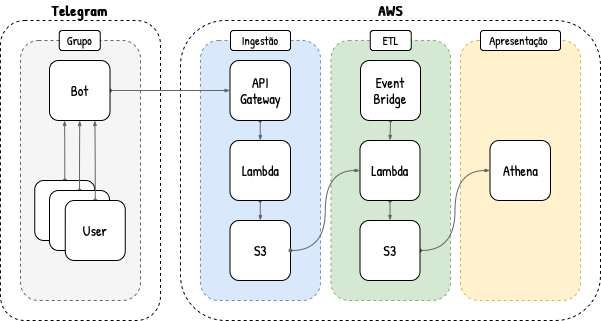

 - **Telegram**

O `Telegram` representa a fonte de dados transacionais. Mensagens enviadas por usuários em um grupo são capturadas por um *bot* e redirecionadas via *webhook* do *backend* do aplicativo para um *endpoint* (endereço *web* que aceita requisições HTTP) exposto pelo `AWS API Gateway`. As mensagens trafegam no corpo ou *payload* da requisição.

 - **AWS | Ingestão**

Uma requisição HTTP com o conteúdo da mensagem em seu *payload* é recebia pelo `AWS API Gateway` que, por sua vez, as redireciona para o `AWS Lambda`, servindo assim como seu gatilho. Já o `AWS Lambda` recebe o *payload* da requisição em seu parâmetro *event*, salva o conteúdo em um arquivo no formato JSON (original, mesmo que o *payload*) e o armazena no `AWS S3` particionado por dia.

 - **AWS | ETL**

Uma vez ao dia, o `AWS Event Bridge` aciona o `AWS Lambda` que processa todas as mensagens do dia anterior (atraso de um dia ou D-1), denormaliza o dado semi-estruturado típico de arquivos no formato JSON, salva o conteúdo processado em um arquivo no formato Apache Parquet e o armazena no `AWS S3` particionado por dia.

 - **AWS | Apresentação**

Por fim, uma tabela do `AWS Athena` é apontada para o *bucket* do `AWS S3` que armazena o dado processado: denormalizado, particionado e orientado a coluna. Profissionais de dados podem então executar consultas analíticas (agregações, ordenações, etc.) na tabela utilizando o SQL para a extração de *insights*.

# **2. Telegram**

O **Telegram** representa a fonte transacional de dados do nosso *pipeline* de dados. Nesta etapa, vamos criar um grupo, criar um **bot** e adiciona-lo ao grupo recém criado. O *bot* então captará **todas** as mensagens enviadas no grupo. As mensagens pode ser acessadas através da API (*application programming interface*) de *bots* dos **Telegram** (documentação neste [link](https://core.telegram.org/bots/api)).

### **2.1. Conta**

Para criar uma conta no **Telegram**, basta fazer o download do aplicativo na loja de aplicativos do seu *smartphone*. Uma vez criada, acesse sua conta através da versão *web* da plataforma de mensagens neste [link](https://web.telegram.org).

### **2.2. Bot**

Para criar um *bot*:

1. Abra o *chat* com o `BotFather`;

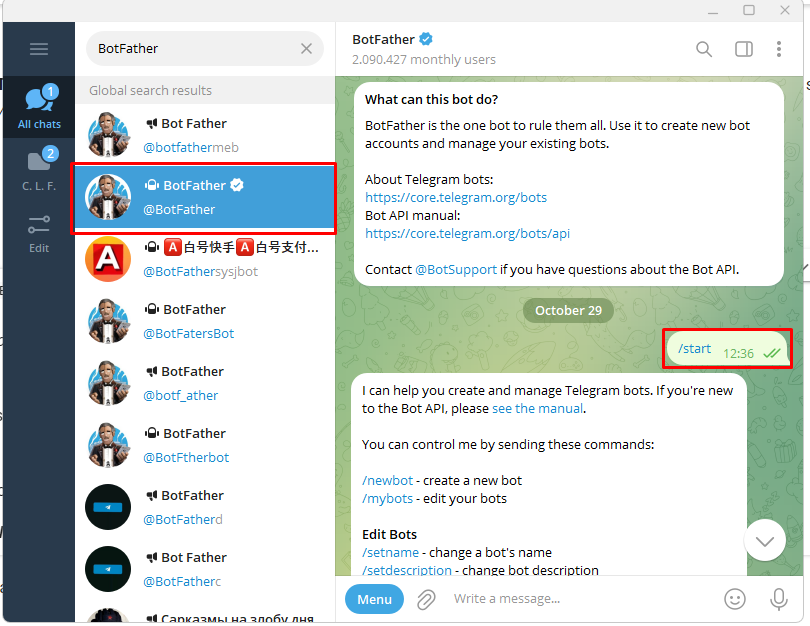

2. Digite `/newbot`;

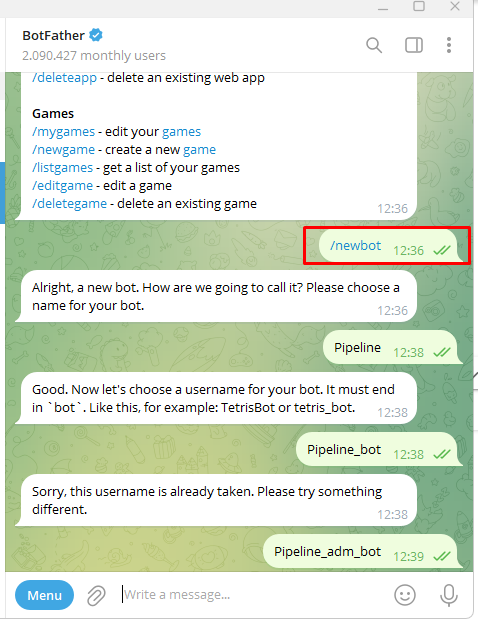



3. Digite o nome do *bot*;

**Pipeline**

4. Digite o nome de usuário do *bot* (precisa terminar com sufixo `_bot`);

**Pipeline_adm_bot**

5. Salve o `token` de acesso a API HTTP em um <font color='red'>local seguro</font>.

[TOKEN](  7888027377:AAGQ4dRW52ogr5JOzD1IfIjgw7Gp8rrUqyg  )



Para conferir o *token* novamente:

1. Abra o *chat* com o `BotFather`;
1. Digite `/mybots`;

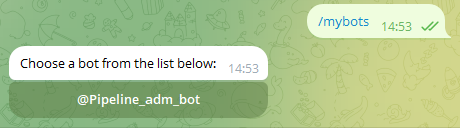

3. Selecione o *bot* pelo seu nome de usuário;
4. Selecione `API Token`.

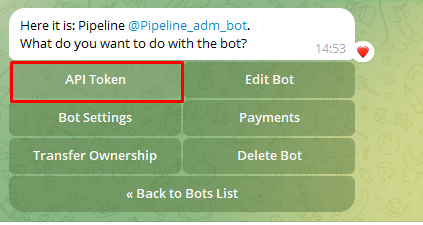


Por fim, precisamos ativiar o *bot*.

1. Abra o *chat* com o *bot*;
1. Selecione `start`.


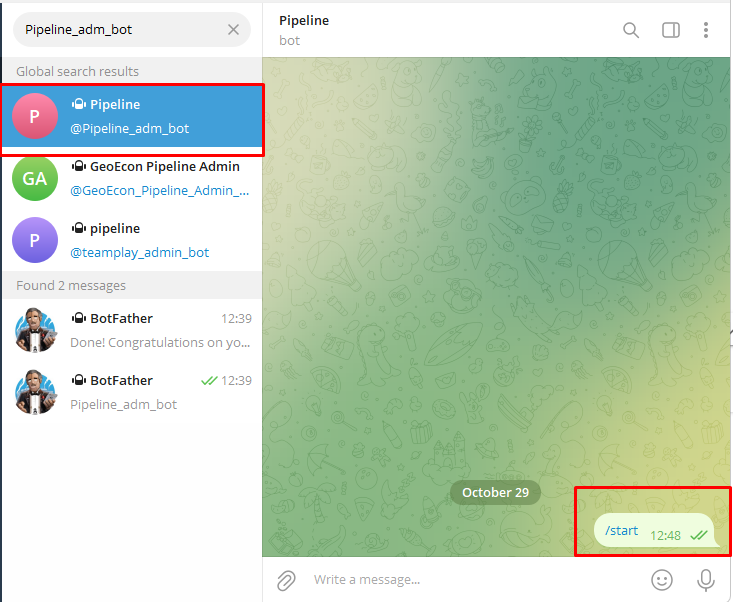

### **2.3. Grupo**

Para criar um novo grupo.

1. Aperte o botão com o ícone de um lápis;
1. Selecione `New Group`;


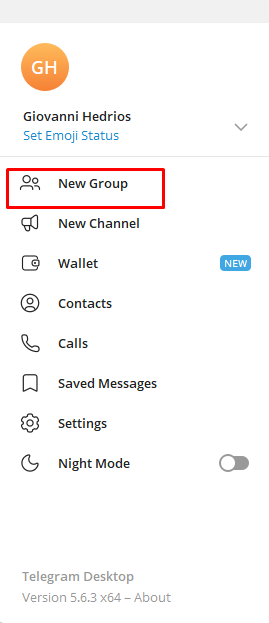


3. Busque e selecione o *bot* recém criado pelo seu nome;
4. Aperte o botão com o ícone de uma seta;
5. Digite o nome do grupo.

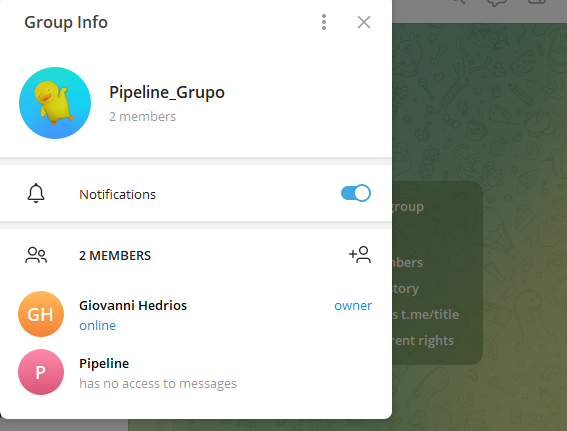


Com o grupo criado, vamos adicionar o *bot* como administrador para que ele possa receber todas as mensagens do grupo. Uma outra opção seria desabilitar o seu modo de privacidade.

1. Abra o *chat* do grupo recém criado;
2. Abra o perfil do grupo;
3. Aperte o botão com o ícone de um lápis;
4. No campo de descrição do grupo escreva: **Atenção, todas as mensagens são armazenadas pelo *bot* do grupo**;

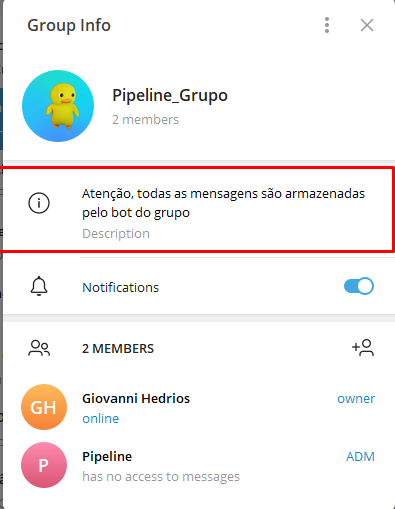


5. Selecione Administrators;
6. Aperte o botão com o ícone de um usuário;
7. Selecione o *bot*.
8. Aperte o botão com o ícone de um *check*.



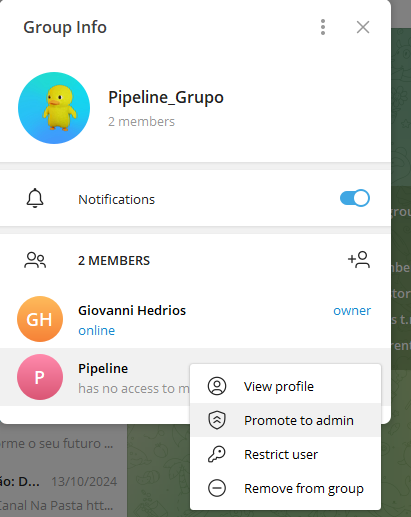

Por fim, vamos configurar o *bot* para que ele não possa ser adicionado a outros grupos.

1. Abra o *chat* com o `BotFather`;
1. Digite `/mybots`;
1. Selecione o *bot* pelo seu nome de usuário;
1. Selecione `Bot Settings`;
1. Selecione `Allow Groups?`;
1. Selecione `Turn groups off`.

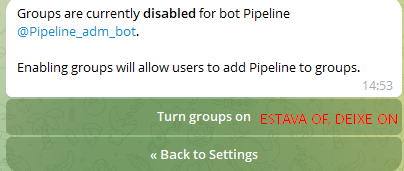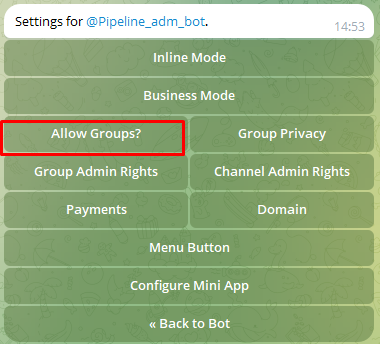

Com tudo pronto, envie algumas mensagens no grupo.

### **2.4. Bot API**

As mensagens captadas por um *bot* podem ser acessadas via API. A única informação necessária é o `token` de acesso fornecido pelo `BotFather` na criação do *bot*.

> **Nota:** A documentação completa da API pode ser encontrada neste [link](https://core.telegram.org/bots/api)

7888027377:AAGQ4dRW52ogr5JOzD1IfIjgw7Gp8rrUqyg

In [ ]:
from getpass import getpass

token = getpass()

··········


A `url` base é comum a todos os métodos da API.

In [ ]:
import json

import requests

base_url = f'https://api.telegram.org/bot{token}'

- **getMe**

O método `getMe` retorna informações sobre o *bot*.

In [ ]:
response = requests.get(url=f'{base_url}/getMe')
print(f'{base_url}/getMe')

print(json.dumps(json.loads(response.text), indent=2))

https://api.telegram.org/bot7888027377:AAGQ4dRW52ogr5JOzD1IfIjgw7Gp8rrUqyg/getMe
{
  "ok": true,
  "result": {
    "id": 7888027377,
    "is_bot": true,
    "first_name": "Pipeline",
    "username": "Pipeline_adm_bot",
    "can_join_groups": false,
    "can_read_all_group_messages": false,
    "supports_inline_queries": false,
    "can_connect_to_business": false,
    "has_main_web_app": false
  }
}


 - **getUpdates**

O método `getMe` retorna as mensagens captadas pelo *bot*.

In [ ]:
response = requests.get(url=f'{base_url}/getUpdates')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": false,
  "error_code": 409,
  "description": "Conflict: can't use getUpdates method while webhook is active; use deleteWebhook to delete the webhook first"
}


# **3. Dados**

Antes de avançar para etapa analítica, vamos trabalhar na manipulação dos dados de mensagens do **Telegram**.

### **3.1. Mensagem**

Uma mensagem recuperada via API é um dado semi-estruturado no formato JSON com algumas chaves mandatórias e diversas chaves opcionais, estas últimas presentes (ou não) dependendo do tipo da mensagem. Por exemplo, mensagens de texto apresentam a chave `text` enquanto mensagens de áudio apresentam a chave `audio`. Neste projeto vamos focar em mensagens do tipo texto, ou seja, vamos ingerir as chaves mandatórias e a chave `text`.

> **Nota**: A lista completa das chaves disponíveis pode ser encontrada na documentação neste [link](https://core.telegram.org/bots/api#message).

 - Exemplo:

In [ ]:
%%writefile telegram.json
{
    "update_id": 123,
    "message": {
        "message_id": 1,
        "from": {
            "id": 321,
            "is_bot": false,
            "first_name": "Andre"
        },
        "chat": {
            "id": -789,
            "type": "group"
        },
        "date": 1640995200,
        "text": "Ola, mundo!"
    }
}

Overwriting telegram.json


 - Descrição:

| chave | tipo valor | opcional | descrição |
| -- | -- | -- | -- |
| updated_id | int | não | id da mensagem enviada ao **bot** |
| message_id | int | não | id da mensagem enviada ao grupo |
| from_id | int | sim | id do usuário que enviou a mensagem |
| from_is_bot | bool | sim | se o usuário que enviou a mensagem é um **bot** |
| from_first_name | str | sim | primeiro nome do usário que enviou a mensagem |
| chat_id | int | não | id do *chat* em que a mensagem foi enviada |
| chat_type | str | não | tipo do *chat*: private, group, supergroup ou channel |
| date | int | não | data de envio da mensagem no formato unix |
| text | str | sim | texto da mensagem |

### **3.2. Wrangling**

Vamos denormalizar o conteúdo da mensagem semi-estruturado no formato JSON utilizando apenas Python nativo, ou seja, sem o auxílio de pacotes, como Pandas.

Para começar, vamos carregar o arquivo `telegram.json` utilizando o pacote nativo `json`.

In [ ]:
import json

with open('telegram.json', mode='r', encoding='utf8') as fp:
  data = json.load(fp)
  data = data["message"]

In [ ]:
print(json.dumps(data, indent=2))

{
  "message_id": 1,
  "from": {
    "id": 321,
    "is_bot": false,
    "first_name": "Andre"
  },
  "chat": {
    "id": -789,
    "type": "group"
  },
  "date": 1640995200,
  "text": "Ola, mundo!"
}


Vamos então utilizar um laço de repetição para varrer todas as chaves do arquivo e selecionar apenas as de interesse. Caso a mensagem não possua a chave `text`, ela será criada com o valor igual a `None`. Além disso, vamos adicionar duas chaves de tempo para indicar o momento em que o dado foi processado: `context_date` e `context_timestamp`.

In [ ]:
from datetime import datetime

date = datetime.now().strftime('%Y-%m-%d')
timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

parsed_data = dict()

for key, value in data.items():

    if key == 'from':
        for k, v in data[key].items():
            if k in ['id', 'is_bot', 'first_name']:
              parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

    elif key == 'chat':
        for k, v in data[key].items():
            if k in ['id', 'type']:
              parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

    elif key in ['message_id', 'date', 'text']:
        parsed_data[key] = [value]

if not 'text' in parsed_data.keys():
  parsed_data['text'] = [None]

parsed_data['context_date'] = [date]
parsed_data['context_timestamp'] = [timestamp]

In [ ]:
for k, v in parsed_data.items():
  print(f"{k}: {v}")

message_id: [1]
user_id: [321]
user_is_bot: [False]
user_first_name: ['Andre']
chat_id: [-789]
chat_type: ['group']
date: [1640995200]
text: ['Ola, mundo!']
context_date: ['2024-10-29']
context_timestamp: ['2024-10-29 19:27:03']


Por fim, vamos utilizar o pacote Python PyArrow para criar uma tabela com os dados processado que, posteriormente, pode ser facilmente persistida em um arquivo no formato Apache Parquet.

In [ ]:
import pyarrow as pa

table = pa.Table.from_pydict(mapping=parsed_data)

In [ ]:
table

pyarrow.Table
message_id: int64
user_id: int64
user_is_bot: bool
user_first_name: string
chat_id: int64
chat_type: string
date: int64
text: string
context_date: string
context_timestamp: string
----
message_id: [[1]]
user_id: [[321]]
user_is_bot: [[false]]
user_first_name: [["Andre"]]
chat_id: [[-789]]
chat_type: [["group"]]
date: [[1640995200]]
text: [["Ola, mundo!"]]
context_date: [["2024-10-29"]]
context_timestamp: [["2024-10-29 19:27:03"]]

# **4. Ingestão**

A etapa de ingestão é responsável, como seu o próprio nome diz, pela ingestão dos dados transacionais em ambientes analíticos. De maneira geral, o dado ingerido é persistido no formato mais próximo do original, ou seja, nenhuma transformação é realizada em seu conteúdo ou estrutura (schema). Como exemplo, dados de uma API web que segue o formato REST (representational state transfer) são entregues, logo, persistidos, no formato JSON.

> Persistir os dados em seu formato original trás muitas vantagens, como a possibilidade de reprocessamento.

Pode ser conduzida de duas formas:



*   Batch: blocos de dados são ingeridos em uma frequência bem definida, geralmente na escala de horas ou dias;

*   Streaming: dados são ingeridos conforme são produzidos e disponibilizados.


Streaming: dados são ingeridos conforme são produzidos e disponibilizados.

No projeto, as mensagens capturadas pelo bot podem ser ingeridas através da API web de bots do Telegram, portanto são fornecidos no formato JSON. Como o Telegram retem mensagens por apenas 24h em seus servidores, a ingestão via streaming é a mais indicada. Para que seja possível esse tipo de ingestão seja possível, vamos utilizar um webhook (gancho web), ou seja, vamos redirecionar as mensagens automaticamente para outra API web.

Sendo assim, precisamos de um serviço da AWS que forneça um API web para receber os dados redirecionados, o AWS API Gateway (documentação neste link). Dentre suas diversas funcionalidades, o AWS API Gateway permite o redirecionamento do dado recebido para outros serviços da AWS. Logo, vamos conecta-lo ao AWS Lambda, que pode sua vez, irá armazenar o dado em seu formato original (JSON) em um bucket do AWS S3.

> Sistemas que reagem a eventos são conhecidos como event-driven.

 - Criar um *bucket* no `AWS S3`;
 - Criar uma função no `AWS Lambda`;
 - Criar uma API *web* no `AWS API Gateway`;
 - Configurar o *webhook* da API de *bots* do **Telegram**.

## **4.1. AWS S3**

Na etapa de ingestão, o AWS S3 tem a função de passivamente armazenar as mensagens captadas pelo bot do Telegram no seu formato original: JSON. Para tanto, basta a criação de um bucket. Como padrão, vamos adicionar o sufixo -raw ao seu nome (vamos seguir esse padrão para todos os serviços desta camada).

> Nota: um data lake é o nome dado a um repositório de um grande volume dados. É organizado em zonas que armazenam replicadas dos dados em diferentes níveis de processamento. A nomenclatura das zonas varia, contudo, as mais comuns são: raw e enriched ou bronze, silver e gold.

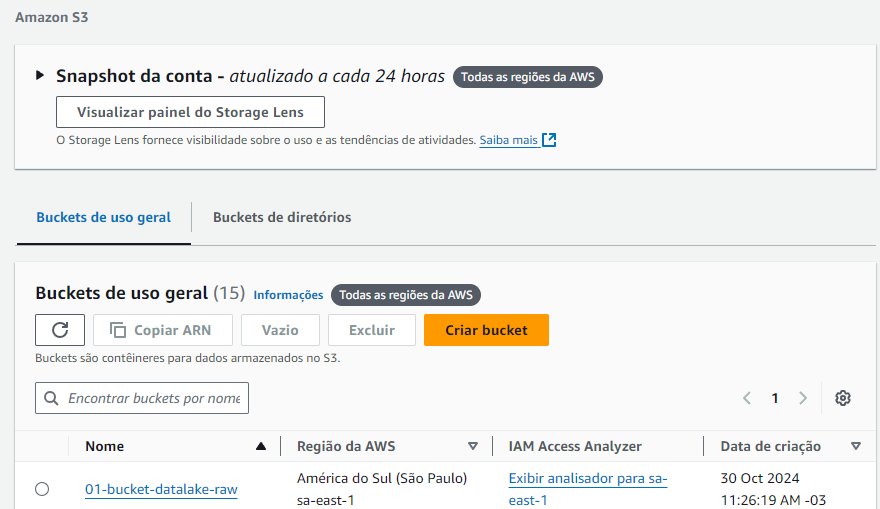

## **4.2. AWS Lambda**

Na etapa de ingestão, o AWS Lambda tem a função de ativamente persistir as mensagens captadas pelo bot do Telegram em um bucket do AWS S3. Para tanto vamos criar uma função que opera da seguinte forma:

 - Recebe a mensagem no parâmetro `event`;
 - Verifica se a mensagem tem origem no grupo do **Telegram** correto;
 - Persiste a mensagem no formato JSON no *bucket* do `AWS S3`;
 - Retorna uma mensagem de sucesso (código de retorno HTTP igual a 200) a API de *bots* do **Telegram**.

> Nota: No Telegram, restringimos a opção de adicionar o bot a grupos, contudo, ainda é possível iniciar uma conversa em um chat privad

**O código da função:**

In [ ]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagensm, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None

      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True

  except Exception as exc:
      logging.error(msg=exc)
      return False

**O código da função de data wrangling:**

In [ ]:
def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

Para que a função funcione corretamente, algumas configurações precisam ser realizadas.

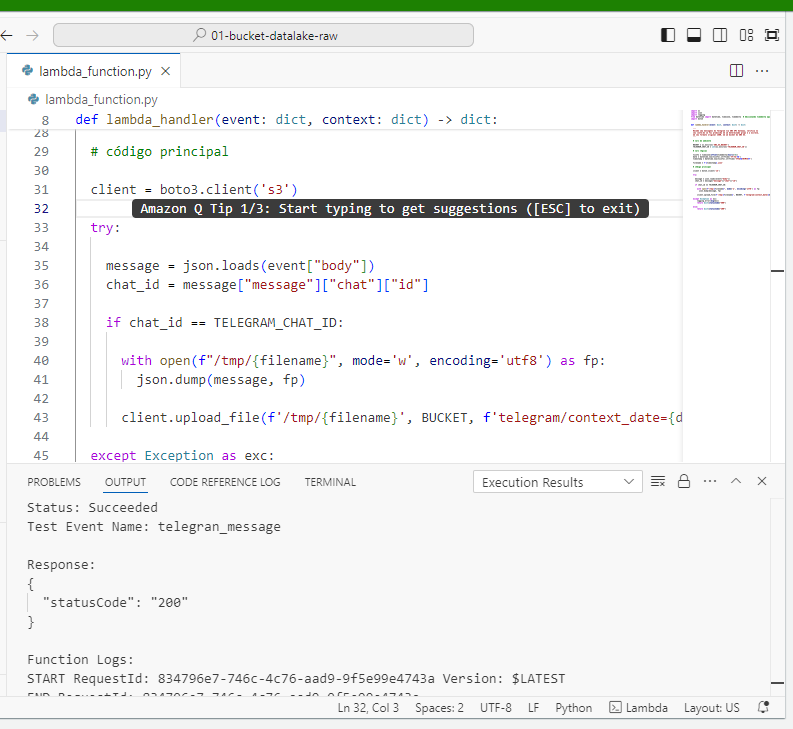

 - **Variáveis de ambiente**

Note que o código exige a configuração de duas variáveis de ambiente: `AWS_S3_BUCKET` com o nome do *bucket* do `AWS S3` e `TELEGRAM_CHAT_ID` com o id do *chat* do grupo do **Telegram**. Para adicionar variáveis de ambiente em uma função do `AWS Lambda`, basta acessar configurações -> variáveis de ambiente no console da função.

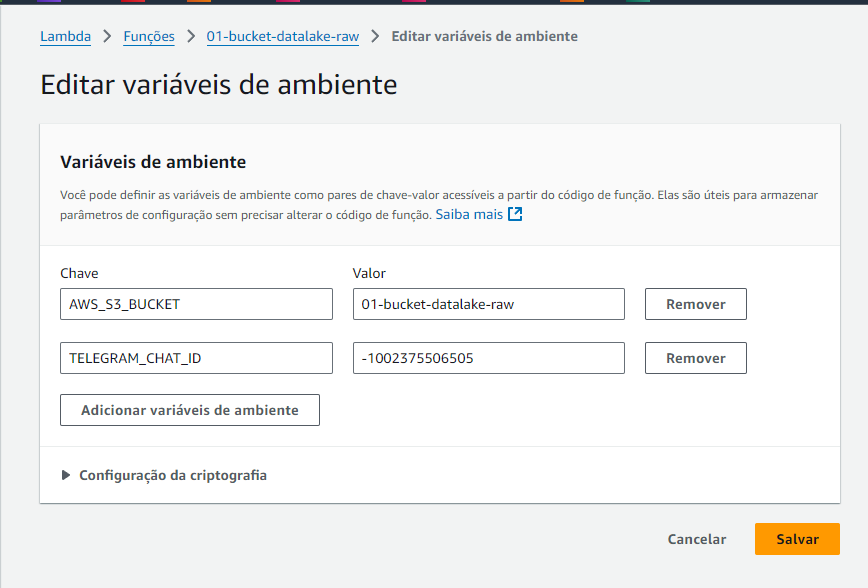

> Nota: Variáveis de ambiente são excelentes formas de armazenar informações sensíveis.

 - **Permissão**

Por fim, precisamos adicionar a permissão de escrita no bucket do AWS S3 para a função do AWS Lambda no AWS IAM.

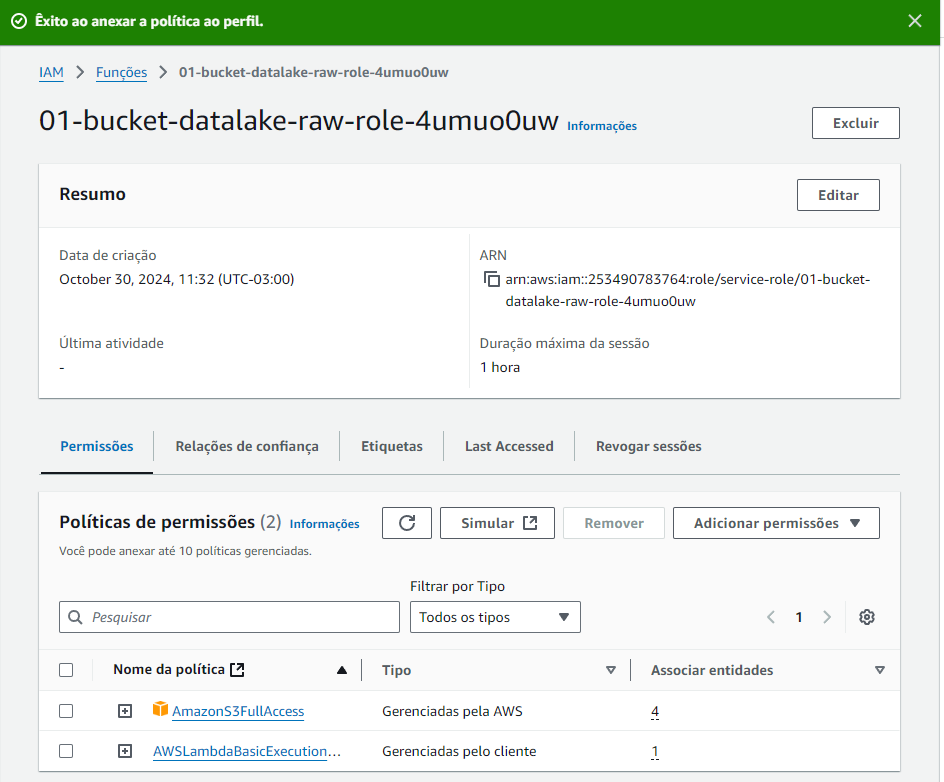

## **4.3. AWS API Gateway**

Na etapa de **ingestão**, o `AWS API Gateway` tem a função de receber as mensagens captadas pelo *bot* do **Telegram**, enviadas via *webhook*, e iniciar uma função do `AWS Lambda`, passando o conteúdo da mensagem no seu parâmetro *event*. Para tanto vamos criar uma API e configurá-la como gatilho da função do `AWS Lambda`:

 - Acesse o serviço e selecione: *Create API* -> *REST API*;
 - Insira um nome, como padrão, um que termine com o sufixo `-api`;
 - Selecione: *Actions* -> *Create Method* -> *POST*;
 - Na tela de *setup*:
  - Selecione *Integration type* igual a *Lambda Function*;
  - Habilite o *Use Lambda Proxy integration*;
  - Busque pelo nome a função do `AWS Lambda`.

Podemos testar a integração com o `AWS Lambda` através da ferramenta de testes do serviço. Por fim, vamos fazer a implantação da API e obter o seu endereço *web*.

 - Selecione: *Actions* -> *Deploy API*;
 - Selecione: *New Stage* para *Deployment stage*;
 - Adicione *dev* como `Stage name`.

Copie o a url gerada na variável aws_api_gateway_url.

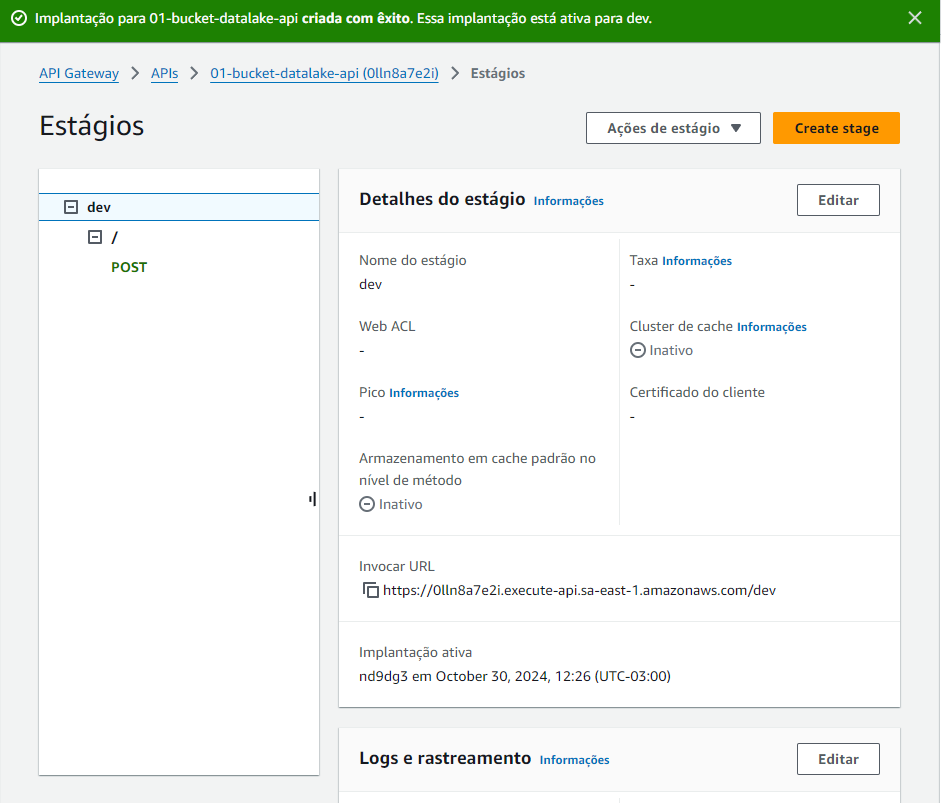

https://ooshw9zew3.execute-api.sa-east-1.amazonaws.com/dev

aws_api_gateway_url = getpass()

## **4.4. Telegram**


Vamos configurar o webhook para redirecionar as mensagens para a url do AWS API Gateway.

 - **setWebhook**

> O método setWebhook configura o redirecionamento das mensagens captadas pelo bot para o endereço web do paramametro url.

> **Nota**: os métodos `getUpdates` e `setWebhook` são mutualmente exclusivos, ou seja, enquanto o *webhook* estiver ativo, o método `getUpdates` não funcionará. Para desativar o *webhook*, basta utilizar o método `deleteWebhook`.

In [ ]:
response = requests.get(url=f'{base_url}/setWebhook?url={aws_api_gateway_url}')

print(json.dumps(json.loads(response.text), indent=2))

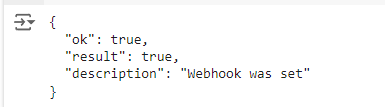

 - **getWebhookInfo**

O método getWebhookInfo retorna as informações sobre o webhook configurado.

In [ ]:
response = requests.get(url=f'{base_url}/getWebhookInfo')

print(json.dumps(json.loads(response.text), indent=2))

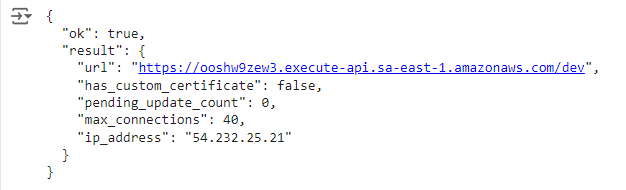

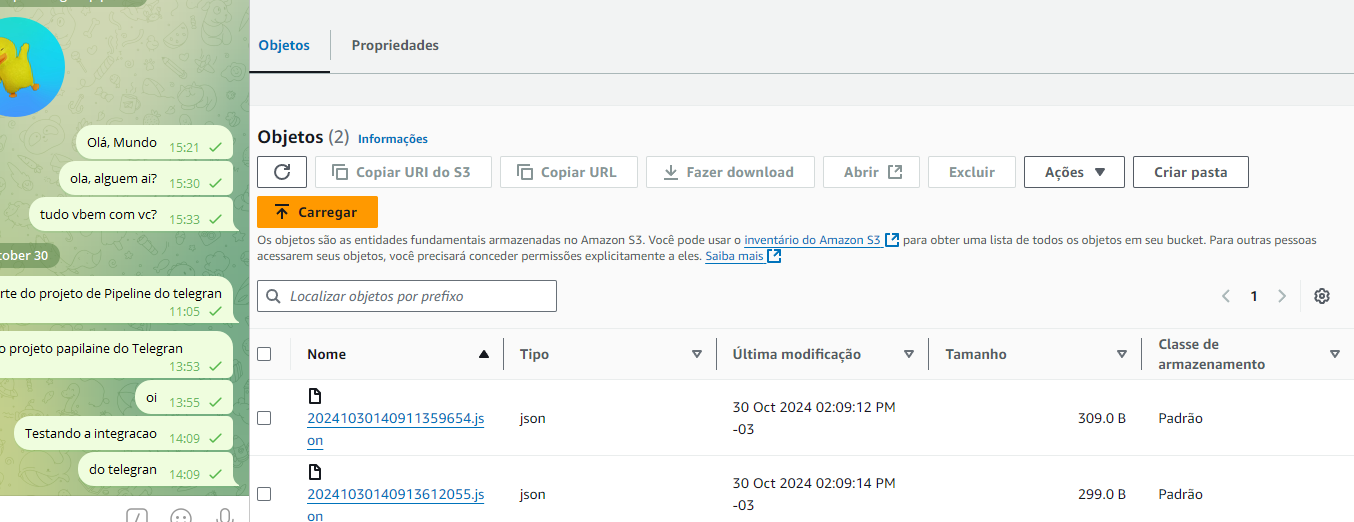

# **5. ETL**

A etapa de **extração, transformação e carregamento** (do inglês *extraction, transformation and load* ou **ETL**) é uma etapa abrangente responsável pela manipulação dos dados ingeridos de sistemas transacionais, ou seja, já persistidos em camadas cruas ou *raw* de sistemas analíticos. Os processos conduzidos nesta etapa variam bastante de acordo com a área da empresa, do volume/variedade/velocidade do dado consumido, etc. Contudo, em geral, o dado cru ingerido passa por um processo recorrente de *data wrangling* onde o dado é limpo, deduplicado, etc. e persistido com técnicas de particionamento, orientação a coluna e compressão. Por fim, o dado processado está pronto para ser analisado por profissionais de dados.

No projeto, as mensagens de um único dia, persistidas na camada cru, serão compactas em um único arquivo, orientado a coluna e comprimido, que será persistido em uma camada enriquecida. Além disso, durante este processo, o dado também passará por etapas de *data wrangling*.

Para isso, vamos utilizar uma função do AWS Lambda como motor de processamento e um bucket do AWS S3 como camada enriquecida para a persistência do dado processado. Para garantir a recorrência, vamos configurar uma regra do AWS Event Bridge como gatilho diáro da função.

## **5.1. AWS S3**

Na etapa de **ETL**, o `AWS S3` tem a função de passivamente armazenar as mensagens processadas de um dia em um único arquivo no formato Parquet. Para tanto, basta a criação de um *bucket*. Como padrão, vamos adicionar o sufixo `-enriched` ao seu nome (vamos seguir esse padrão para todos os serviços desta camada).

> **Nota**: um `data lake` é o nome dado a um repositório de um grande volume dados. É organizado em zonas que armazenam replicadas dos dados em diferentes níveis de processamento. A nomenclatura das zonas varia, contudo, as mais comuns são: *raw* e *enriched* ou *bronze*, *silver* e *gold*.

## **5.2. AWS Lambda**

Na etapa de **ETL**, o `AWS Lambda` tem a função de ativamente processar as mensagens captadas pelo *bot* do **Telegram**, persistidas na camada cru no *bucket* do `AWS S3`, e persisti-las na camada enriquecida, também em um *bucket* do `AWS S3`. Logo, vamos criar uma função que opera da seguinte forma:

 - Lista todos os arquivos JSON de uma única participação da camada crua de um *bucket* do `AWS S3`;
 - Para cada arquivo listado:
  - Faz o *download* do arquivo e carrega o conteúdo da mensagem;
  - Executa uma função de *data wrangling*;
  - Cria uma tabela do PyArrow e a contatena com as demais.
 - Persiste a tabela no formato Parquet na camada enriquecida em um *bucket* do `AWS S3`.

> **Nota**: O fato de utilizarmos duas camadas de armazenamento e processamento, permite que possamos reprocessar os dados crus de diversas maneiras, quantas vezes forem preciso.

> **Nota**: Atente-se ao fato de que a função processa as mensagens do dia anterior (D-1).

In [ ]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagensm, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None

      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True

  except Exception as exc:
      logging.error(msg=exc)
      return False

O código da função de data wrangling:

In [ ]:
def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

Para que a função funcione corretamente, algumas configurações precisam ser realizadas.

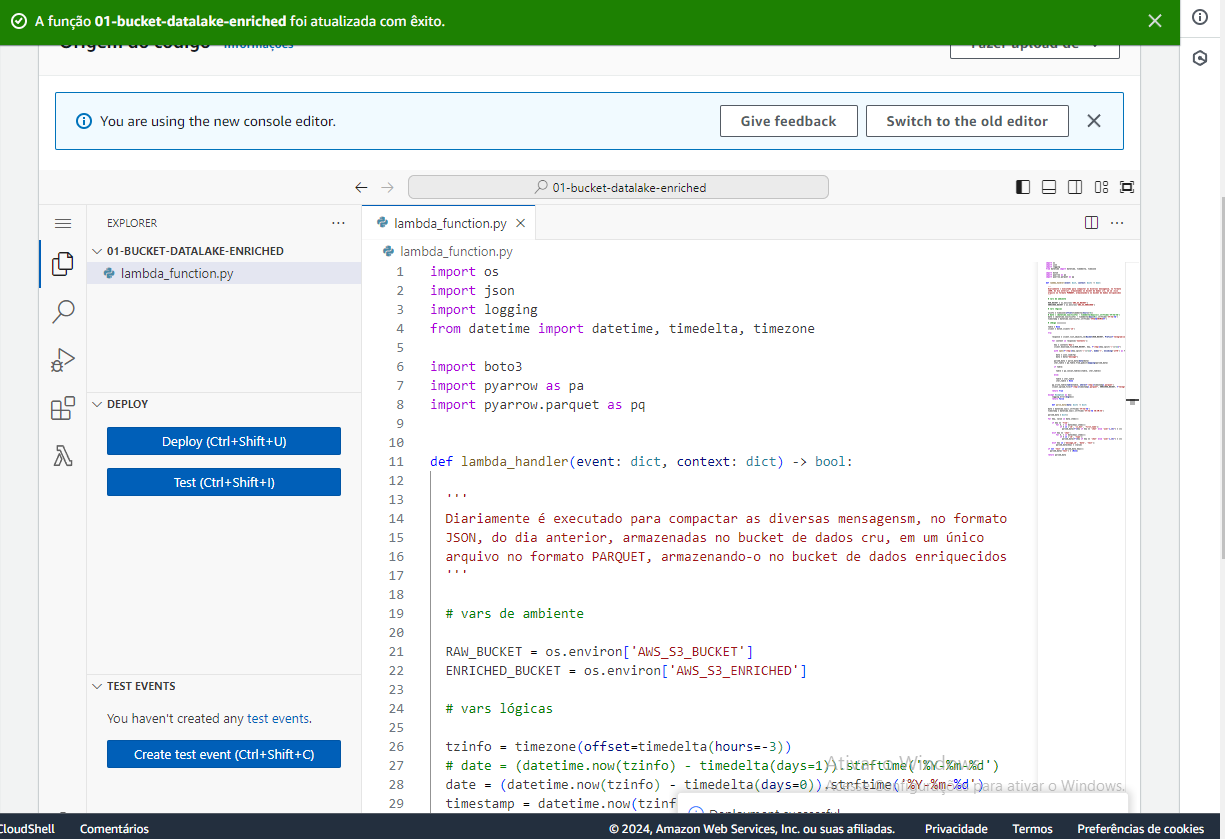

 - **Variáveis de ambiente**

Note que o código exige a configuração de duas variáveis de ambiente: `AWS_S3_BUCKET` e `AWS_S3_ENRICHED` com os nomes dos *bucket* do `AWS S3` da camada cru e enriquecida, respectivamente. Para adicionar variáveis de ambiente em uma função do `AWS Lambda`, basta acessar configurações -> variáveis de ambiente no console da função.

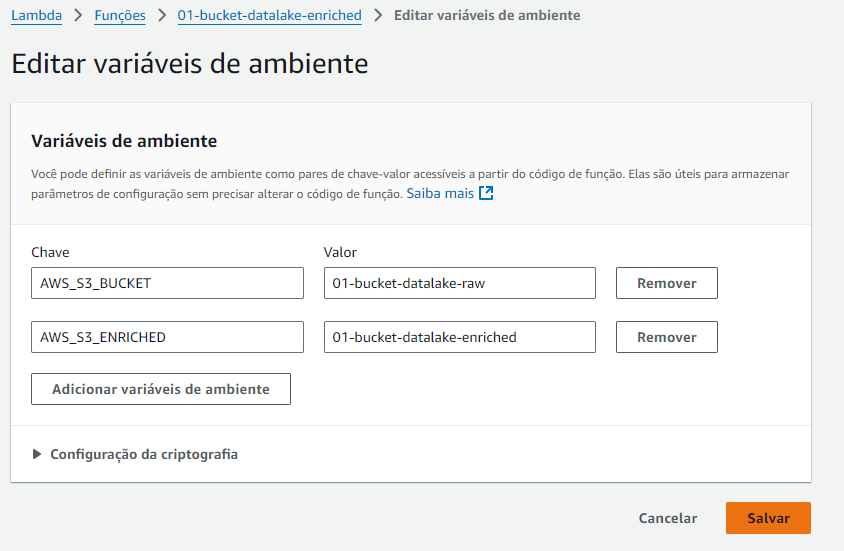

**Permissão**

Precisamos adicionar a permissão de escrita nos *buckets* do `AWS S3` para a função do `AWS Lambda` no `AWS IAM`.

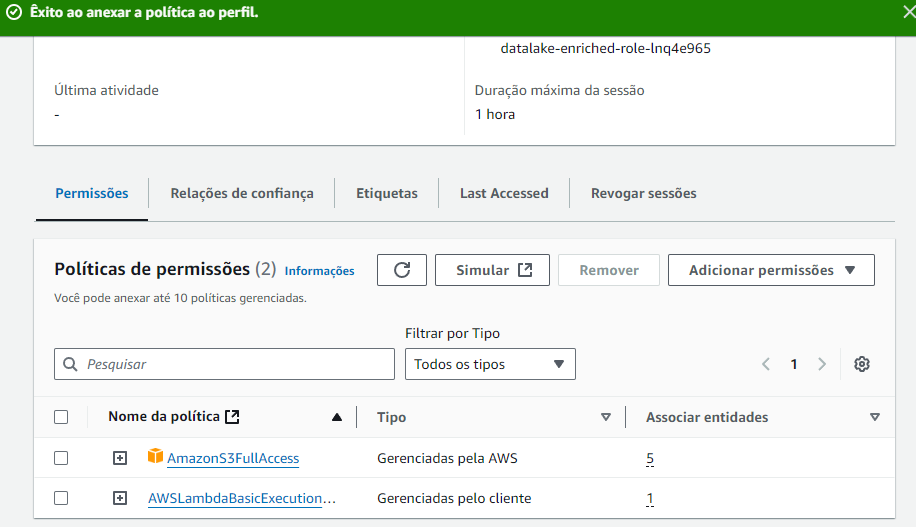

 - **Recursos**

O *timeout* padrão de funcões do `AWS Lambda` é de 3 segundos. Para a função, vamos aumentar o tempo para 5 minutos, principalmente para lidar com o IO (*input/output*) de arquivos do `AWS S3`.

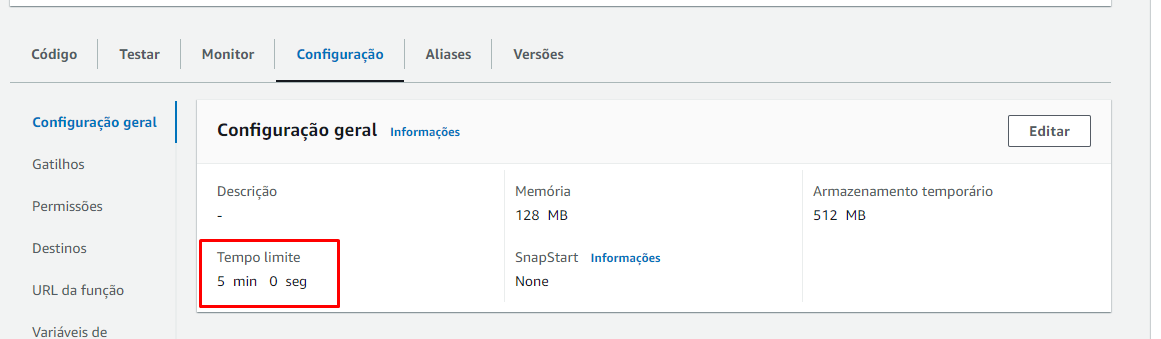

 - **Camadas**

Por fim, note que o código da função utiliza o pacote Python PyArrow. Contudo, o ambiente padrão do `AWS Lambda` possui poucos pacotes externos instalado, como o pacote Python boto3, logo o PyArrow não será encontrado e a execução da função falhará. Existem algumas formas de adicionar pacotes externos no ambiente de execução do AWS Lambda, um deles é a criação de camadas ou *layers*, onde podemos fazer o *upload* dos pacotes Python direto na plataforma ou através de um *bucket* do `AWS S3`. Vamos então seguir com a última opção, onde teremos que:

 - Criar um *bucket* no `AWS S3`;
 - Fazer o *upload* do código do pacote Python do PyArrow (*download* neste) : https://github.com/awslabs/aws-data-wrangler/releases;
 - Criar *layer* e conectar na função.

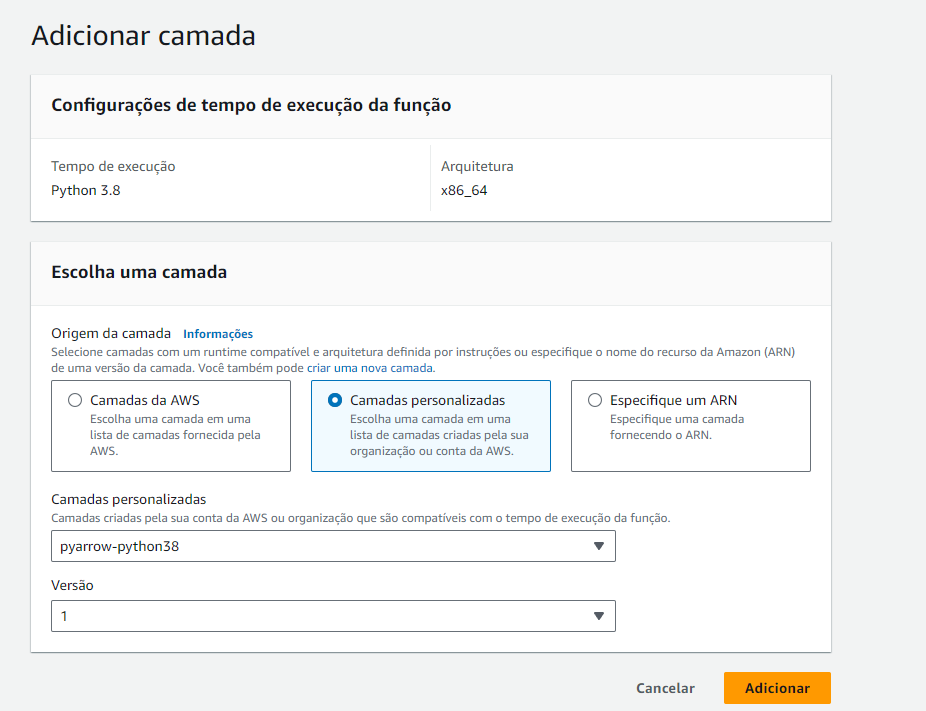

## **5.3. AWS Event Bridge**

Na etapa de **ETL**, o `AWS Event Bridge` tem a função de ativar diariamente a função de **ETL** do `AWS Lambda`, funcionando assim como um *scheduler*.

> **Nota**: Atente-se ao fato de que a função processa as mensagens do dia anterior (D-1).

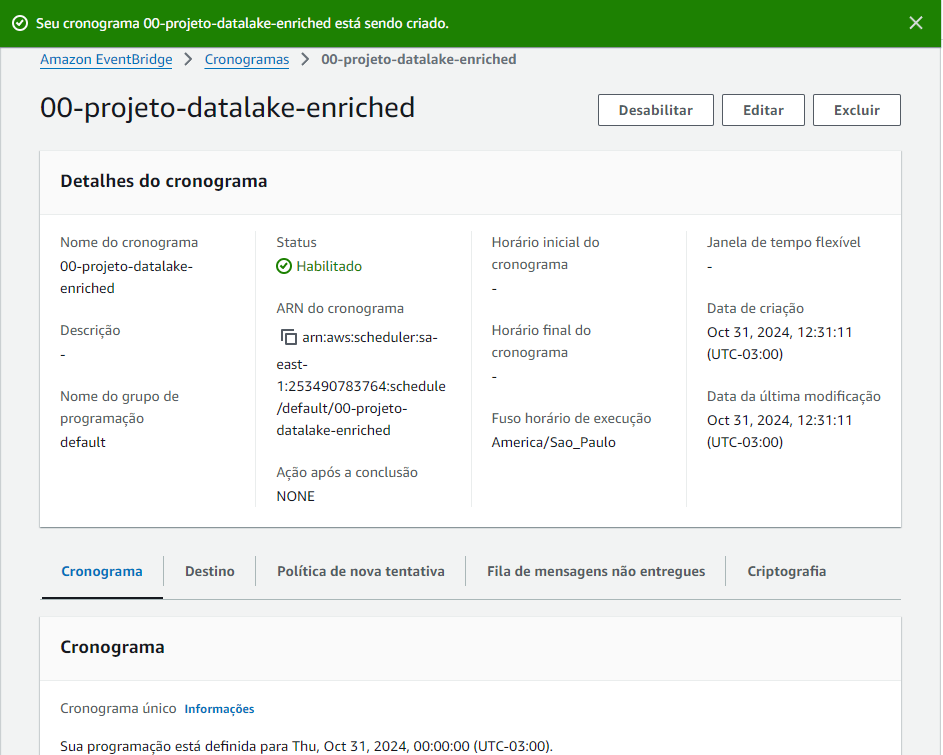

# **6. Apresentação**

A etapa de **apresentação** é reponsável por entregar o dado para os usuários (analistas, cientistas, etc.) e sistemas (dashboards, motores de consultas, etc.), idealmente através de uma interface de fácil uso, como o SQL, logo, essa é a única etapa que a maioria dos usuários terá acesso. Além disso, é importante que as ferramentas da etapa entregem dados armazenados em camadas refinadas, pois assim as consultas são mais baratas e o dados mais consistentes.

## **6.1. AWS Athena**

Na etapa de **apresentação**, o `AWS Athena` tem função de entregar o dados através de uma interface SQL para os usuários do sistema analítico. Para criar a interface, basta criar uma tabela externa sobre o dado armazenado na camada mais refinada da arquitetura, a camada enriquecida.

```sql
CREATE EXTERNAL TABLE `telegram`(
  `message_id` bigint,
  `user_id` bigint,
  `user_is_bot` boolean,
  `user_first_name` string,
  `chat_id` bigint,
  `chat_type` string,
  `text` string,
  `date` bigint)
PARTITIONED BY (
  `context_date` date)
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION
  's3://<bucket-enriquecido>/'
```

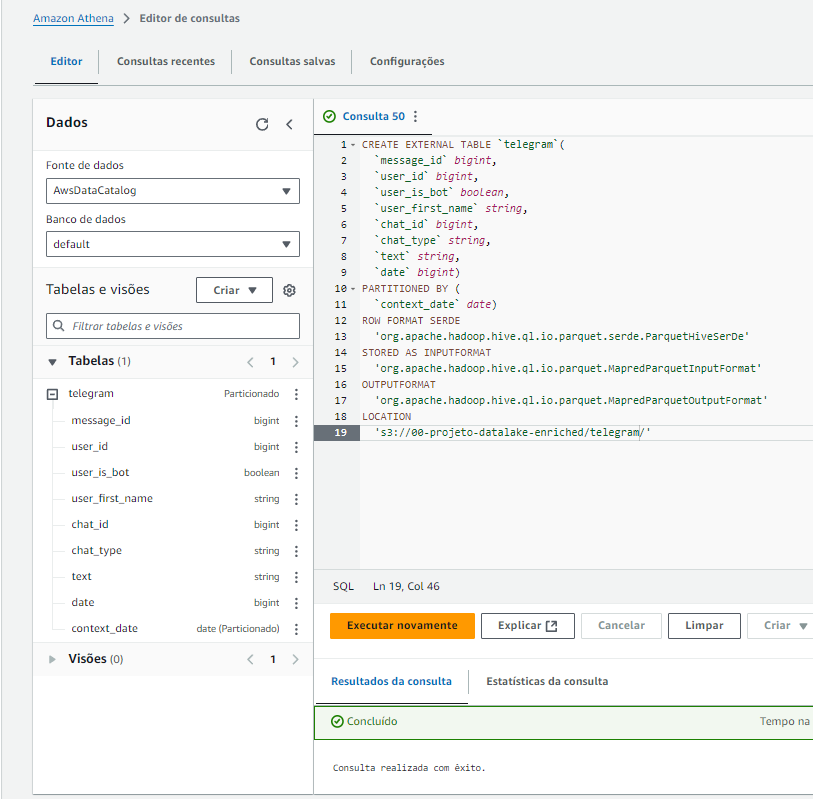

Por fim, adicione as partições disponíveis.

> **Importante**: Toda vez que uma nova partição é adicionada ao repositório de dados, é necessário informar o `AWS Athena` para que a ela esteja disponível via SQL. Para isso, use o comando SQL `MSCK REPAIR TABLE <nome-tabela>` para todas as partições (mais caro) ou `ALTER TABLE <nome-tabela> ADD PARTITION <coluna-partição> = <valor-partição>` para uma única partição (mais barato), documentação neste [link](https://docs.aws.amazon.com/athena/latest/ug/alter-table-add-partition.html)).

MSCK REPAIR TABLE `telegram`;

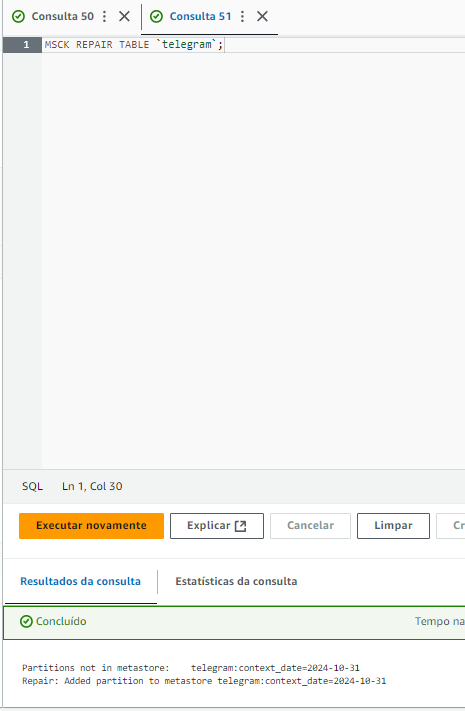

E consulte as 10 primeiras linhas para observar o resultado.

```sql
SELECT * FROM `telegram` LIMIT 10;
```

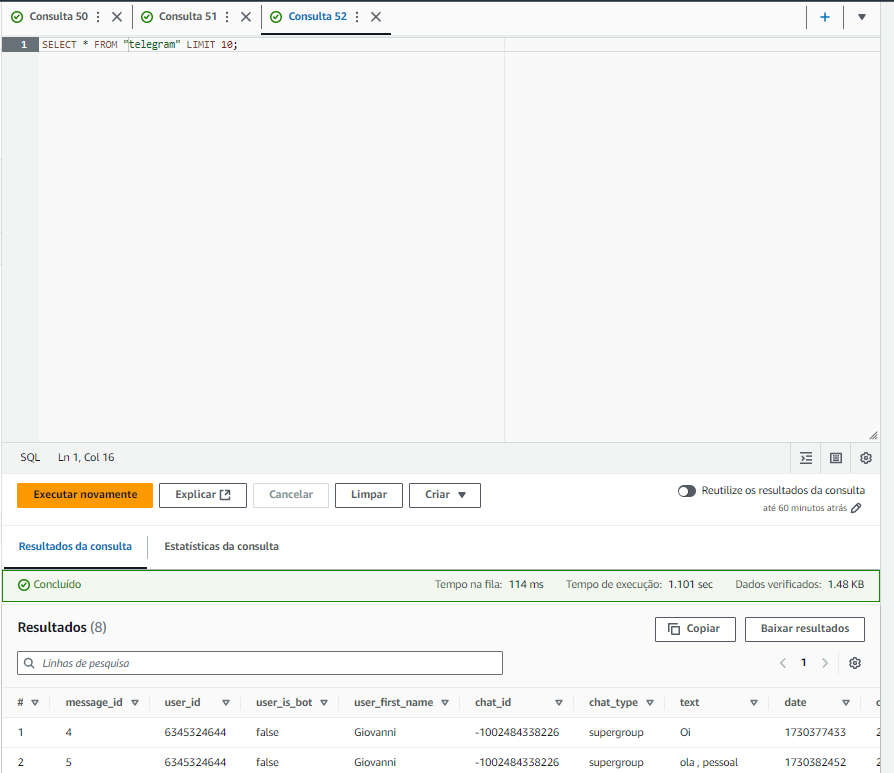

## **6.2. Analytics**

Com o dado disponível, usuário podem executar as mais variadas consultas analíticas. Seguem alguns exemplos:

- Quantidade de mensagens por dia.

```sql
SELECT
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY context_date
ORDER BY context_date DESC
```

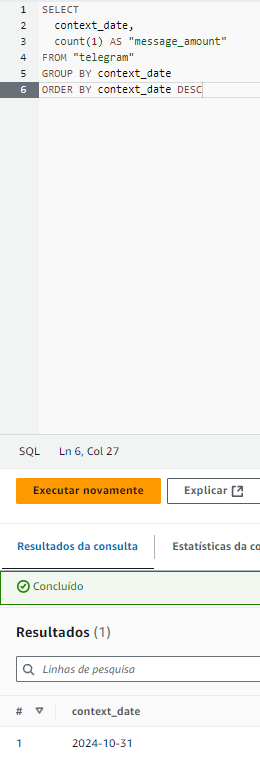

- Quantidade de mensagens por usuário por dia.

```sql
SELECT
  user_id,
  user_first_name,
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC
```

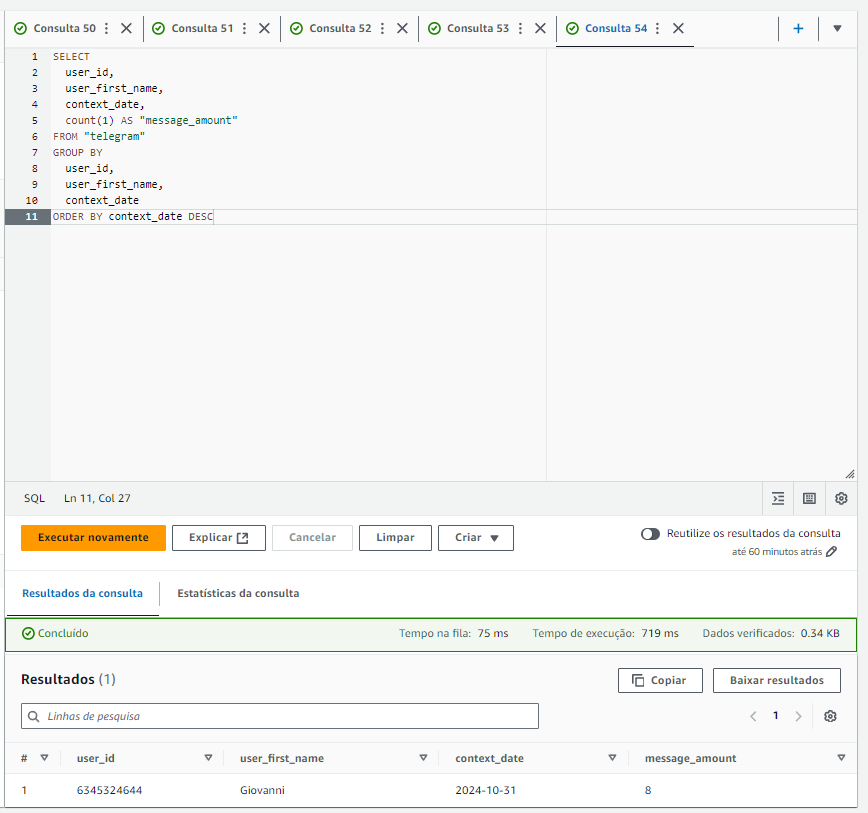

- Média do tamanho das mensagens por usuário por dia.

```sql
SELECT
  user_id,
  user_first_name,
  context_date,
  CAST(AVG(length(text)) AS INT) AS "average_message_length"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC
```

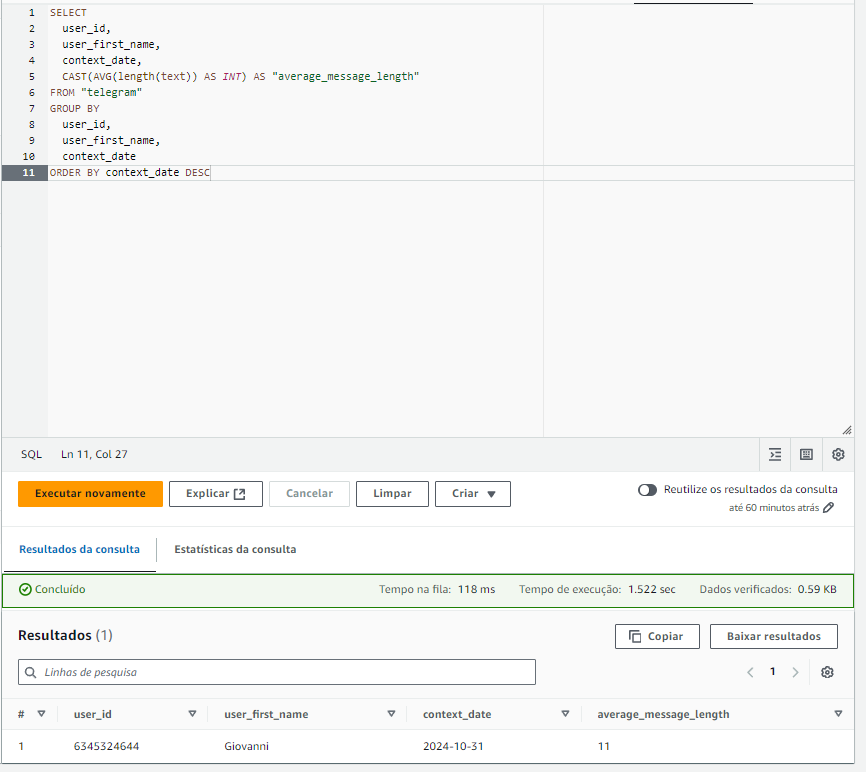

- Quantidade de mensagens por hora por dia da semana por número da semana.

```sql
WITH
parsed_date_cte AS (
    SELECT
        *,
        CAST(date_format(from_unixtime("date"),'%Y-%m-%d %H:%i:%s') AS timestamp) AS parsed_date
    FROM "telegram"
),
hour_week_cte AS (
    SELECT
        *,
        EXTRACT(hour FROM parsed_date) AS parsed_date_hour,
        EXTRACT(dow FROM parsed_date) AS parsed_date_weekday,
        EXTRACT(week FROM parsed_date) AS parsed_date_weeknum
    FROM parsed_date_cte
)
SELECT
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum,
    count(1) AS "message_amount"
FROM hour_week_cte
GROUP BY
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum
ORDER BY
    parsed_date_weeknum,
    parsed_date_weekday
```

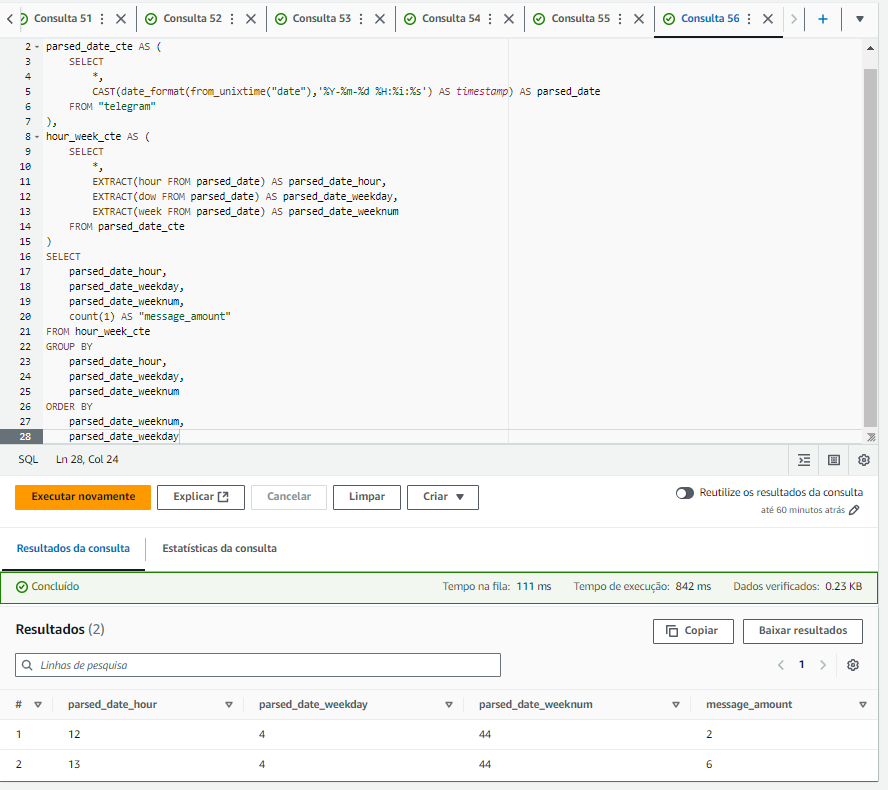

# **7 Conclusão**

O pipeline de dados do Telegram implementado oferece uma solução completa para captura, processamento e análise de mensagens enviadas a um chatbot no Telegram, aproveitando a infraestrutura da AWS. Desde a ingestão inicial das mensagens até a disponibilização de dados refinados para análise, o pipeline foi cuidadosamente projetado para garantir flexibilidade e escalabilidade. A utilização de camadas de armazenamento — dados brutos e dados processados — permite que os dados sejam mantidos em seu formato original e facilmente reprocessados quando necessário, assegurando a integridade e a precisão das informações.

O uso do AWS API Gateway, AWS Lambda e AWS S3 automatiza o fluxo de dados em cada etapa, enquanto o AWS Athena fornece uma interface SQL intuitiva para consultas, permitindo que analistas de dados extraiam insights sem a necessidade de manipular dados manualmente. Este pipeline não só facilita a análise em tempo real como também reduz a carga de trabalho dos profissionais de dados, que podem se concentrar na interpretação dos resultados para gerar valor ao negócio. Em resumo, este pipeline representa uma abordagem robusta e eficiente para gerenciar e analisar dados de interação com o chatbot no Telegram, destacando-se pela organização e pela capacidade de atender a demandas analíticas complexas com facilidade.